<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/CasualAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import gc
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Style settings for nice plots
plt.style.use('seaborn-v0_8-whitegrid')

Mounted at /content/drive


In [2]:
#  Load Data & Optimize Memory

# Load Data
file_path = '/content/drive/My Drive/instacart_train_data.pkl'
print(f"Loading data from {file_path}...")
df = pd.read_pickle(file_path)

#  Define Variables
# Morning Order (6am - 12pm)
if 'order_hour_of_day' in df.columns:
    df['is_morning'] = df['order_hour_of_day'].apply(lambda x: 1 if 6 <= x <= 12 else 0)
else:
    # Fallback if 'order_hour_of_day' is also missing (unlikely, but safe)
    print("Warning: 'order_hour_of_day' missing. creating dummy column.")
    df['is_morning'] = 0

# Reordered
df['outcome'] = df['reordered']

#  Smart Column Selection
# We only select confounders that ACTUALLY EXIST in your dataframe
potential_confounders = ['order_number', 'days_since_prior_order', 'order_dow']
valid_confounders = [c for c in potential_confounders if c in df.columns]

print(f"Confounders found: {valid_confounders}")
if len(valid_confounders) < len(potential_confounders):
    print(f"Missing confounders: {set(potential_confounders) - set(valid_confounders)}")

columns_to_keep = ['outcome', 'is_morning'] + valid_confounders

#  Create Analysis Subset & Cleanup
print("Creating analysis set and deleting raw data...")
analysis_df = df[columns_to_keep].sample(n=100000, random_state=42).copy()

# MEMORY CLEANUP
del df
gc.collect()

print(f"Memory optimized. Analysis set shape: {analysis_df.shape}")
print(analysis_df.head())

Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Confounders found: ['days_since_prior_order', 'order_dow']
Missing confounders: {'order_number'}
Creating analysis set and deleting raw data...
Memory optimized. Analysis set shape: (100000, 4)
          outcome  is_morning  days_since_prior_order  order_dow
8615761         1           0                     2.0          3
6968744         0           1                    14.0          5
4487543         0           1                    14.0          1
12302754        1           0                    30.0          4
12698687        0           0                    22.0          1


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [3]:
# Naive A/B Test (Correlation)

# Calculate simple averages
naive_group = analysis_df.groupby('is_morning')['outcome'].mean()
morning_rate = naive_group[1]
other_rate = naive_group[0]
naive_effect = morning_rate - other_rate

print(f"Morning Reorder Rate: {morning_rate:.2%}")
print(f"Other Reorder Rate:   {other_rate:.2%}")
print(f"Naive Difference:     {naive_effect:.2%}")

Morning Reorder Rate: 10.08%
Other Reorder Rate:   9.75%
Naive Difference:     0.34%


In [4]:
#  Causal Inference (Regression)

#  Prepare Variables
X = analysis_df[['is_morning'] + valid_confounders]
X = sm.add_constant(X) # Add intercept
y = analysis_df['outcome']

#  Fit Model
print("Running Logistic Regression to control for confounders...")
model = sm.Logit(y, X).fit(disp=0)

# Get the  Morning Effect
coef = model.params['is_morning']
p_val = model.pvalues['is_morning']
# Convert log-odds to approximate % impact
causal_effect = np.exp(coef) - 1

print(f"Causal Impact of Morning: {causal_effect:.2%}")
print(f"P-Value: {p_val:.4f}")

Running Logistic Regression to control for confounders...
Causal Impact of Morning: 4.22%
P-Value: 0.0560


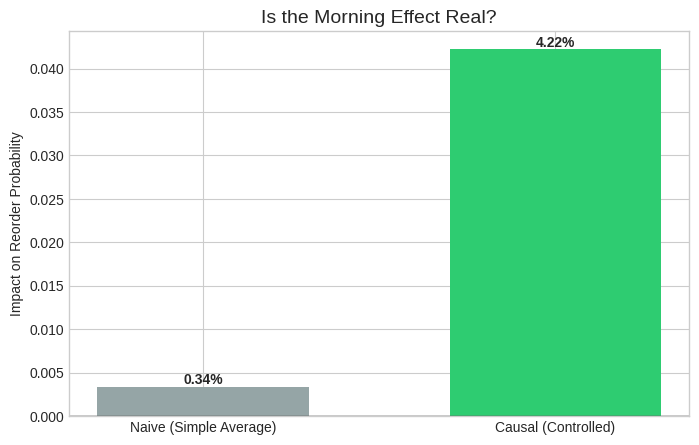

In [5]:
# Naive vs Causal Impact

effects = [naive_effect, causal_effect]
labels = ['Naive (Simple Average)', 'Causal (Controlled)']
colors = ['#95a5a6', '#2ecc71'] # Grey vs Green

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, effects, color=colors, width=0.6)
plt.axhline(0, color='black', linewidth=1)

# Label bars
for bar, val in zip(bars, effects):
    plt.text(bar.get_x() + bar.get_width()/2, val, f'{val:.2%}',
             ha='center', va='bottom' if val>0 else 'top', fontweight='bold')

plt.title('Is the Morning Effect Real?', fontsize=14)
plt.ylabel('Impact on Reorder Probability')
plt.show()

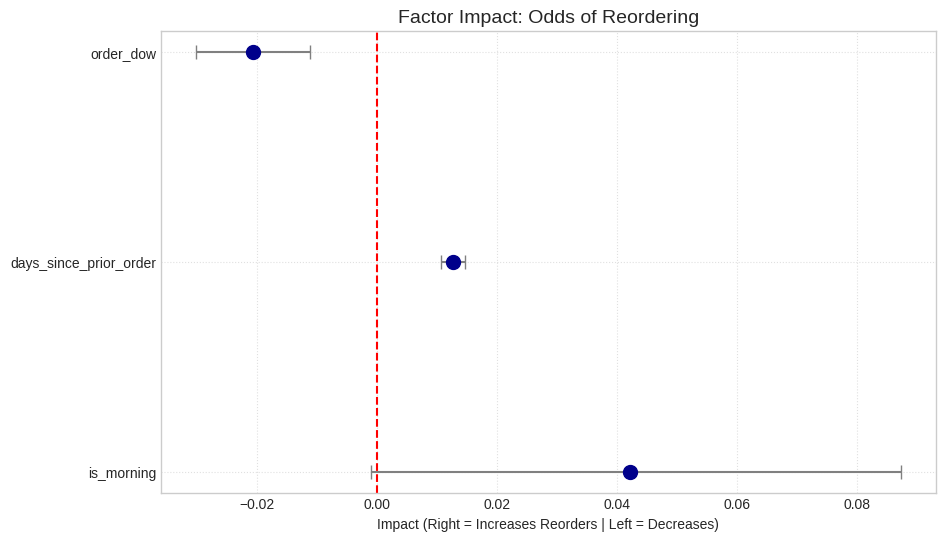

Interpretation: Variables to the right of the red line INCREASE reorder chance.


In [6]:
# Odds Ratios (Forest Plot)

# Extract Odds Ratios and Confidence Intervals
params = model.params.drop('const')
conf = model.conf_int().drop('const')
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
conf = np.exp(conf) # Convert log-odds to Odds Ratios

# Plot
plt.figure(figsize=(10, 6))
# We subtract 1 so that 0 is the baseline
errors = [conf['OR'] - conf['2.5%'], conf['97.5%'] - conf['OR']]

plt.errorbar(x=conf['OR'] - 1, y=conf.index, xerr=errors, fmt='o',
             color='darkblue', ecolor='gray', capsize=5, markersize=10)

plt.axvline(0, color='red', linestyle='--')
plt.title('Factor Impact: Odds of Reordering', fontsize=14)
plt.xlabel('Impact (Right = Increases Reorders | Left = Decreases)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

print("Interpretation: Variables to the right of the red line INCREASE reorder chance.")